# Basic multi-agent simulation with steric interactions

In [13]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import copy

import time
from typing import Tuple, Iterable
from functools import partial
from typing import NamedTuple, Any
import random as rm

from matplotlib.colors import Normalize
import matplotlib.cm as cm

import importlib
# Function for plots
import plotFns as pF
# Parameters in the model
import multPrmts as pR

In [14]:
colors = {
    "gray": {
        0: "#f8f9fa",
        1: "#f1f3f5",
        2: "#e9ecef",
        3: "#dee2e6",
        4: "#ced4da",
        5: "#adb5bd",
        6: "#868e96",
        7: "#495057",
        8: "#343a40",
        9: "#212529",
    },
    "red": {
        0: "#fff5f5",
        1: "#ffe3e3",
        2: "#ffc9c9",
        3: "#ffa8a8",
        4: "#ff8787",
        5: "#ff6b6b",
        6: "#fa5252",
        7: "#f03e3e",
        8: "#e03131",
        9: "#c92a2a",
    },
    "pink": {
        0: "#fff0f6",
        1: "#ffdeeb",
        2: "#fcc2d7",
        3: "#faa2c1",
        4: "#f783ac",
        5: "#f06595",
        6: "#e64980",
        7: "#d6336c",
        8: "#c2255c",
        9: "#a61e4d",
    },
    "grape": {
        0: "#f8f0fc",
        1: "#f3d9fa",
        2: "#eebefa",
        3: "#e599f7",
        4: "#da77f2",
        5: "#cc5de8",
        6: "#be4bdb",
        7: "#ae3ec9",
        8: "#9c36b5",
        9: "#862e9c",
    },
    "violet": {
        0: "#f3f0ff",
        1: "#e5dbff",
        2: "#d0bfff",
        3: "#b197fc",
        4: "#9775fa",
        5: "#845ef7",
        6: "#7950f2",
        7: "#7048e8",
        8: "#6741d9",
        9: "#5f3dc4",
    },
    "indigo": {
        0: "#edf2ff",
        1: "#dbe4ff",
        2: "#bac8ff",
        3: "#91a7ff",
        4: "#748ffc",
        5: "#5c7cfa",
        6: "#4c6ef5",
        7: "#4263eb",
        8: "#3b5bdb",
        9: "#364fc7",
    },
    "blue": {
        0: "#e7f5ff",
        1: "#d0ebff",
        2: "#a5d8ff",
        3: "#74c0fc",
        4: "#4dabf7",
        5: "#339af0",
        6: "#228be6",
        7: "#1c7ed6",
        8: "#1971c2",
        9: "#1864ab",
    },
    "cyan": {
        0: "#e3fafc",
        1: "#c5f6fa",
        2: "#99e9f2",
        3: "#66d9e8",
        4: "#3bc9db",
        5: "#22b8cf",
        6: "#15aabf",
        7: "#1098ad",
        8: "#0c8599",
        9: "#0b7285",
    },
    "teal": {
        0: "#e6fcf5",
        1: "#c3fae8",
        2: "#96f2d7",
        3: "#63e6be",
        4: "#38d9a9",
        5: "#20c997",
        6: "#12b886",
        7: "#0ca678",
        8: "#099268",
        9: "#087f5b",
    },
    "green": {
        0: "#ebfbee",
        1: "#d3f9d8",
        2: "#b2f2bb",
        3: "#8ce99a",
        4: "#69db7c",
        5: "#51cf66",
        6: "#40c057",
        7: "#37b24d",
        8: "#2f9e44",
        9: "#2b8a3e",
    },
    "lime": {
        0: "#f4fce3",
        1: "#e9fac8",
        2: "#d8f5a2",
        3: "#c0eb75",
        4: "#a9e34b",
        5: "#94d82d",
        6: "#82c91e",
        7: "#74b816",
        8: "#66a80f",
        9: "#5c940d",
    },
    "yellow": {
        0: "#fff9db",
        1: "#fff3bf",
        2: "#ffec99",
        3: "#ffe066",
        4: "#ffd43b",
        5: "#fcc419",
        6: "#fab005",
        7: "#f59f00",
        8: "#f08c00",
        9: "#e67700",
    },
    "orange": {
        0: "#fff4e6",
        1: "#ffe8cc",
        2: "#ffd8a8",
        3: "#ffc078",
        4: "#ffa94d",
        5: "#ff922b",
        6: "#fd7e14",
        7: "#f76707",
        8: "#e8590c",
        9: "#d9480f",
    },
    "mixed": {
        0: "#880e4f",
        1: "#1a237e",
        2: "#e65100",
        3: "#004d40",
        4: "#c92a2a",
    },
}

### Steric interactions check

In [10]:
p = pR.params()
xvec = np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh)
xphm, yphm = np.meshgrid(xvec, xvec)
cInit = np.zeros((p.nMsh, p.nMsh))
for ix in range(p.nMsh):
    for iy in range(p.nMsh):
        r = np.sqrt(xphm[ix][iy]**2+yphm[ix][iy]**2)
        if (r > (p.a-p.pt))  & (r < (p.a+p.pt)) & (yphm[ix][iy] >= 0):
            cInit[ix][iy] = 1.
        else:
            cInit[ix][iy] = 0.

class phrmn():
    def __init__(self, cInit):
        super().__init__()
        self.c = cInit
    
    def gener(self, xphm, yphm, rAg, ptr):
        p = copy.deepcopy(ptr)
        for ix in range(p.nMsh):
            for iy in range(p.nMsh):
                r = np.sqrt((rAg[0] - xphm[ix][iy])**2+(rAg[1]-yphm[ix][iy])**2)
                if r <= p.pt:
                    self.c[ix][iy] = 1.0

# Interpolate value of pheromone to location r 
def phmChk(r, c):
    cVal = sp.interpolate.interp2d(xvec, xvec, c, kind='cubic')
    return cVal(r[0], r[1])
phm = phrmn(cInit)

In [16]:
phm = phrmn(cInit)
# Worker class
class worker():
    global phm
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.r = p.rInit
        self.thet = p.thetInit
        #Worker variables
        self.dirCtrl = np.ones(p.nAgnts) #Controls direction of motion: 1 -  Anti-clockwise; -1 - Clockwise
        
    def wkPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        phi = np.arctan2(self.r[1], self.r[0])
        self.thet = phi + 0.5*np.pi*self.dirCtrl + np.random.uniform(-np.pi/5, np.pi/5, p.nAgnts)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        
        #Makes sure that worker is within pheromone region
        fInd = np.where(np.linalg.norm(self.r, axis=0) > (p.a+p.pt-p.l))
        if np.size(fInd) > 0:
            self.thet[fInd] = self.thet[fInd] + self.dirCtrl[fInd]*np.pi*0.25
            self.r[0][fInd] += p.l*np.cos(self.thet[fInd])
            self.r[1][fInd] += p.l*np.sin(self.thet[fInd])
        fInd = np.where(np.linalg.norm(self.r, axis=0) < (p.a-p.pt+p.l))
        if np.size(np.where(np.linalg.norm(self.r, axis=0) < (p.a-p.pt))) > 0:    
            self.thet[fInd] = self.thet[fInd] - self.dirCtrl[fInd]*np.pi*0.25
            self.r[0][fInd] += p.l*np.cos(self.thet[fInd])
            self.r[1][fInd] += p.l*np.sin(self.thet[fInd])

        #Checks if target is reached and flip direction of motion
        clsChk = np.array([self.r[0] - p.tgt[0], self.r[1] - p.tgt[1]])
        fInd = np.where(np.linalg.norm(clsChk, axis=0) < 0.1)
        if np.size(fInd) > 0:
            self.dirCtrl[fInd] = -1.
        #Checks if home is reached and flip direction of motion
        clsChk = np.array([self.r[0] - p.strt[0], self.r[1] - p.strt[1]])
        fInd = np.where(np.linalg.norm(clsChk, axis=0) < 0.1)
        if np.size(fInd) > 0:
            self.dirCtrl[fInd] = 1.
    
    def reset(self, ptr):
        p = copy.deepcopy(ptr)
        self.r = p.rInit
        self.thet = p.thetInit
        self.dirCtrl = np.ones(p.nAgnts) #Controls direction of motion: 1 -  Anti-clockwise; -1 - Clockwise

In [17]:
def repelWkrs(r, ptr):
    p = copy.deepcopy(ptr)
    delta = (r[..., np.newaxis] - r[:, np.newaxis]).T
    distances = np.linalg.norm(delta, axis=-1)
    
    unit_vector = (delta.T / distances).T
    unit_vector[np.isnan(unit_vector)] = 0 # replace NaN values with 0
    
    charge_matrix = np.ones((p.nAgnts, p.nAgnts))
    force = -24*1e-3*charge_matrix/distances**13
    force[np.isinf(force)] = 0 # NaN forces are 0
    acc = (unit_vector.T * force).T.sum(axis=1)

    fInd = np.where(np.triu(distances) == 0.)
    distances[fInd] = 10.
    fInd = np.where(distances < (3*p.sz))
    fInd = np.unique(np.array(fInd).flatten())
    r[:,fInd] += p.dt*acc.T[:,fInd] ###Make it act only when distance is less than a limit
    return r[:,:p.nAgnts], r[:,p.nAgnts:p.nAgnts+p.nForag]

In [ ]:
importlib.reload(pF)
importlib.reload(pR)

p = pR.params()
wk = worker(p)
phm = phrmn(cInit)

fig, ax = pF.plotDefMul(5, p, xphm, yphm, phm)

phiPtn = np.linspace(0, np.pi, p.nPtn+1)
start_time = time.time()

# for eInd in range(p.nEpchs):
for eInd in range(2):
    p = pR.params()
    # Worker data
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    phxFull = np.array(np.cos(p.thetInit))
    phyFull = np.array(np.sin(p.thetInit))
 
    while fg.sInd <= p.nSteps:
        # Worker dynamics
        wk.wkPolicy(p)
        # Forager dynamics
        if fg.sInd < p.nSc:
            fg.intPolicy(p)
        elif fg.sInd == p.nSc:
            #Orientation of the target from given location
            tgtOrn = (p.tgt - fg.r)/np.linalg.norm(p.tgt - fg.r) #Orientation of the target from given location
            p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
            #Diffusion as a function of \phi_c or equivalently s_c
            fg.phiSc = np.arctan2(fg.r[1], fg.r[0])
            p.diff = p.diffCst/(np.pi - np.arctan2(fg.r[1],fg.r[0]))
            fg.ouPolicy(p)
            fg.rSc = fg.r
        elif fg.tgtInd == 1:
            fg.piPolicy(p)
            if fg.sInd%20  == 0:
                phm.gener(xphm, yphm, fg.r, p)
        else:
            fg.ouPolicy(p)
        
        #Reward check
        if np.linalg.norm(fg.r - p.tgt) < p.sigma:
            fg.rwd += (np.pi - fg.phiSc)*p.a
            fg.tgtInd = 1
        if np.linalg.norm(fg.r) > (p.a+p.pt+0.1):
            fg.sInd = p.nSteps
            
        fg.sTrl += p.l
        fg.sInd += 1
        
        # Repelsive interaction after each step
        [wk.r, fg.r] = repel(wk.r, fg.r, p)
        fg.r = fg.r.reshape(2,)
        
        rxFull = np.vstack((rxFull, np.array(wk.r[0])))
        rfgxFull = np.vstack((rfgxFull, np.array(fg.r[0])))
        ryFull = np.vstack((ryFull, np.array(wk.r[1])))
        rfgyFull = np.vstack((rfgyFull, np.array(fg.r[1])))
        phxFull = np.vstack((phxFull, np.array(np.cos(wk.thet))))
        phfgxFull = np.vstack((phfgxFull, np.array(np.cos(fg.thet))))
        phyFull = np.vstack((phyFull, np.array(np.sin(wk.thet))))
        phfgyFull = np.vstack((phfgyFull, np.array(np.sin(fg.thet))))
        rwdFull = np.vstack((rwdFull, np.array(fg.rwd)))
    
    iVal = np.where(phiPtn <= fg.phiSc)
    
    #TD(0)-learning value function update rule
    fg.valFn[iVal[0][-1]] = fg.valFn[iVal[0][-1]]*(1 - p.alpha) + fg.rwd*p.alpha
    
    #Reset agent to initial location
    fg.reset(p)
    
    pF.plotMultFg(fig, ax, p, rfgxFull, rfgyFull, phfgxFull, phfgyFull, rwdFull, fg.valFn, 0.5)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

 ## <a class="anchor" id="first-bullet">Agents walking along semi-circular track by following pheromone</a>

In [3]:
p = pR.params()
xvec = np.linspace(-1.5*p.a, 1.5*p.a, p.nMsh)
xphm, yphm = np.meshgrid(xvec, xvec)
cInit = np.zeros((p.nMsh, p.nMsh))
for ix in range(p.nMsh):
    for iy in range(p.nMsh):
        r = np.sqrt(xphm[ix][iy]**2+yphm[ix][iy]**2)
        if (r > (p.a-p.pt))  & (r < (p.a+p.pt)) & (yphm[ix][iy] >= 0):
            cInit[ix][iy] = 1.
        else:
            cInit[ix][iy] = 0.

class phrmn():
    def __init__(self, cInit):
        super().__init__()
        self.c = cInit
    
    def gener(self, xphm, yphm, rAg, ptr):
        p = copy.deepcopy(ptr)
        for ix in range(p.nMsh):
            for iy in range(p.nMsh):
                r = np.sqrt((rAg[0] - xphm[ix][iy])**2+(rAg[1]-yphm[ix][iy])**2)
                if r <= p.pt:
                    self.c[ix][iy] = 1.0

# Interpolate value of pheromone to location r 
def phmChk(r, c):
    cVal = sp.interpolate.interp2d(xvec, xvec, c, kind='cubic')
    return cVal(r[0], r[1])
phm = phrmn(cInit)

In [4]:
phm = phrmn(cInit)
# Worker class
class worker():
    global phm
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.r = p.rInit
        self.thet = p.thetInit
        
        #Worker variables
        self.dirCtrl = np.ones(p.nAgnts) #Controls direction of motion: 1 -  Anti-clockwise; -1 - Clockwise
        
    def wkPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        
        phi = np.arctan2(self.r[1], self.r[0])
        self.thet = phi + 0.5*np.pi*self.dirCtrl + np.random.uniform(-np.pi/5, np.pi/5, p.nAgnts)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        
        #Makes sure that worker is within pheromone region
        fInd = np.where(np.linalg.norm(self.r, axis=0) > (p.a+p.pt-p.l))
        if np.size(fInd) > 0:
            self.thet[fInd] = self.thet[fInd] + self.dirCtrl[fInd]*np.pi*0.25
            self.r[0][fInd] += p.l*np.cos(self.thet[fInd])
            self.r[1][fInd] += p.l*np.sin(self.thet[fInd])
        fInd = np.where(np.linalg.norm(self.r, axis=0) < (p.a-p.pt+p.l))
        if np.size(np.where(np.linalg.norm(self.r, axis=0) < (p.a-p.pt))) > 0:    
            self.thet[fInd] = self.thet[fInd] - self.dirCtrl[fInd]*np.pi*0.25
            self.r[0][fInd] += p.l*np.cos(self.thet[fInd])
            self.r[1][fInd] += p.l*np.sin(self.thet[fInd])

        #Checks if target is reached and flip direction of motion
        clsChk = np.array([self.r[0] - p.tgt[0], self.r[1] - p.tgt[1]])
        fInd = np.where(np.linalg.norm(clsChk, axis=0) < 0.1)
        if np.size(fInd) > 0:
            self.dirCtrl[fInd] = -1.
        #Checks if home is reached and flip direction of motion
        clsChk = np.array([self.r[0] - p.strt[0], self.r[1] - p.strt[1]])
        fInd = np.where(np.linalg.norm(clsChk, axis=0) < 0.1)
        if np.size(fInd) > 0:
            self.dirCtrl[fInd] = 1.
    
    def reset(self, ptr):
        p = copy.deepcopy(ptr)
        self.r = p.rInit
        self.thet = p.thetInit
        self.dirCtrl = np.ones(p.nAgnts) #Controls direction of motion: 1 -  Anti-clockwise; -1 - Clockwise

In [5]:
# Forager class
class forager():
    global phm
    def __init__(self, ptr):
        super().__init__()
        p = copy.deepcopy(ptr)
        self.r = p.rFgInit #position of agent
        self.thet = p.thetFgInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent
        self.valFn = np.zeros(p.nPtn) #value function initialized to zero
        self.phiSc = 0. #angle at which bifurcation happens
        self.tgtInd = 0 #indicates if target was reached 0 - not reached, 1 - reached
        self.hmInd = 0 #indicates if on way to home from rSc
        self.rSc = np.array([0., 0.]) #location of bifurcation
        
    def intPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        phi = np.arctan2(self.r[1], self.r[0])
        self.thet = phi + 0.5*np.pi + np.random.uniform(-np.pi/5, np.pi/5)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.rwd += np.exp(-phi/p.phiSt)*p.l
        
        if np.linalg.norm(self.r) > (p.a+p.pt):
            self.thet = self.thet + np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
            
        if np.linalg.norm(self.r) < (p.a-p.pt):
            self.thet = self.thet - np.pi*0.25
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
    
    def ouPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        self.thet = self.thet*(1-p.nu*p.dt) + p.nu*p.dt*p.tgtPhi + np.sqrt(2*p.diff*p.dt)*np.random.normal()
        
    def piPolicy(self, ptr):
        p = copy.deepcopy(ptr)
        if (np.linalg.norm(self.rSc - self.r) > p.l) & (self.hmInd == 0):
            tgtOrn = (self.rSc - self.r)/np.linalg.norm(self.rSc - self.r) #Orientation of the target from given location
            p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
            self.thet = p.tgtPhi
            self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
        elif (np.linalg.norm(self.rSc - self.r) < p.l) & (self.hmInd == 0):
            self.hmInd = 1
        elif self.hmInd == 1:
            phi = np.arctan2(self.r[1], self.r[0])
            self.thet = phi - 0.5*np.pi + np.random.uniform(-np.pi/5, np.pi/5)
            tmp = np.array([np.cos(self.thet), np.sin(self.thet)])
            self.r += p.l*tmp
            #Makes sure that forager is within pheromone region
            if np.linalg.norm(self.r) > (p.a+p.pt):
                self.thet = self.thet - np.pi*0.25
                self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
            
            if np.linalg.norm(self.r) < (p.a-p.pt):
                self.thet = self.thet + np.pi*0.25
                self.r += p.l*np.array([np.cos(self.thet), np.sin(self.thet)])
                
            if np.linalg.norm(self.r - p.strt) <= p.pt:
                self.sInd = p.nSteps

    
    def reset(self, ptr):
        p = copy.deepcopy(ptr)
        self.r = p.rFgInit #position of agent
        self.thet = p.thetFgInit #local orientation of agent
        self.rwd = 0.0 #reward collected
        self.sTrl = 0.0 #distance travelled by agent
        self.sInd = 0 #step count of agent

In [6]:
def repel(r1, r2, ptr):
    p = copy.deepcopy(ptr)
    r = np.hstack((r1, r2.reshape(2, p.nForag)))
    delta = (r[..., np.newaxis] - r[:, np.newaxis]).T
    distances = np.linalg.norm(delta, axis=-1)
    
    unit_vector = (delta.T / distances).T
    unit_vector[np.isnan(unit_vector)] = 0 # replace NaN values with 0
    
    charge_matrix = np.ones((p.nAgnts+p.nForag, p.nAgnts+p.nForag))
    force = 1e-3*charge_matrix / distances
    force[np.isinf(force)] = 0 # NaN forces are 0
    acc = (unit_vector.T * force).T.sum(axis=1)

    fInd = np.where(np.triu(distances) == 0.)
    distances[fInd] = 10.
    fInd = np.where(distances < (3*p.sz))
    fInd = np.unique(np.array(fInd).flatten())
    r[:,fInd] += p.dt*acc.T[:,fInd] ###Make it act only when distance is less than a limit
    return r[:,:p.nAgnts], r[:,p.nAgnts:p.nAgnts+p.nForag]

/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_49770/661043085.py:7: RuntimeWarning: invalid value encountered in divide
  unit_vector = (delta.T / distances).T
/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_49770/661043085.py:11: RuntimeWarning: divide by zero encountered in divide
  force = 1e-3*charge_matrix / distances
/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_49770/661043085.py:7: RuntimeWarning: invalid value encountered in divide
  unit_vector = (delta.T / distances).T
/var/folders/hq/qfn7h8h16pvdp93670td9g8w0000gn/T/ipykernel_49770/661043085.py:11: RuntimeWarning: divide by zero encountered in divide
  force = 1e-3*charge_matrix / distances


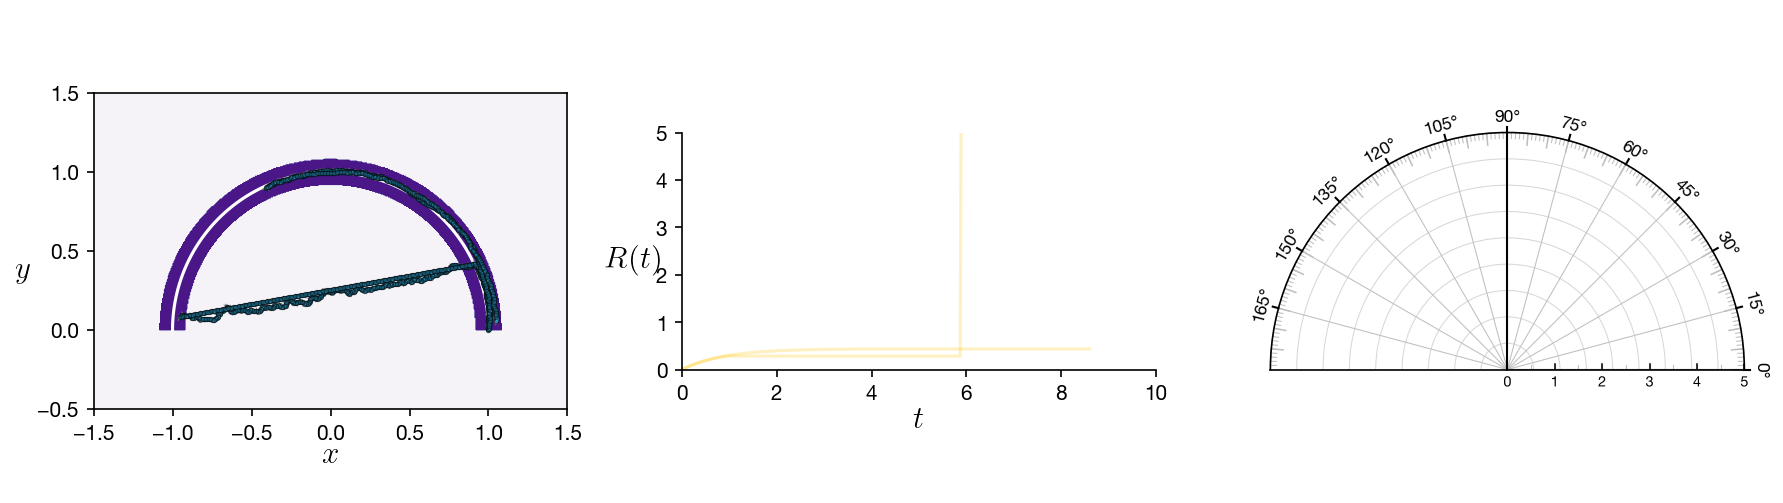

--- 20.62692403793335 seconds ---


In [7]:
importlib.reload(pF)
importlib.reload(pR)

p = pR.params()
wk = worker(p)
fg = forager(p)
phm = phrmn(cInit)

fig, ax = pF.plotDefMul(5, p, xphm, yphm, phm)

phiPtn = np.linspace(0, np.pi, p.nPtn+1)
start_time = time.time()

# for eInd in range(p.nEpchs):
for eInd in range(2):
    p = pR.params()
    # Worker data
    rxFull = np.array(p.rInit[0])
    ryFull = np.array(p.rInit[1])
    phxFull = np.array(np.cos(p.thetInit))
    phyFull = np.array(np.sin(p.thetInit))
    # Forager data
    rfgxFull = np.array(p.rFgInit[0])
    rfgyFull = np.array(p.rFgInit[1])
    phfgxFull = np.array(np.cos(p.thetFgInit))
    phfgyFull = np.array(np.sin(p.thetFgInit))
    rwdFull = np.array(0.0)
    # epsilon-greedy policy
    if (np.random.uniform() < p.epsilon) or (eInd < 100):
        p.nSc = np.random.uniform(0,np.pi)*(p.a-p.pt)//p.l
    else:
        iVmax = np.argmax(fg.valFn)
        p.nSc =  phiPtn[iVmax]//p.l

    while fg.sInd <= p.nSteps:
        # Worker dynamics
        wk.wkPolicy(p)
        # Forager dynamics
        if fg.sInd < p.nSc:
            fg.intPolicy(p)
        elif fg.sInd == p.nSc:
            #Orientation of the target from given location
            tgtOrn = (p.tgt - fg.r)/np.linalg.norm(p.tgt - fg.r) #Orientation of the target from given location
            p.tgtPhi = np.arctan2(tgtOrn[1], tgtOrn[0])
            #Diffusion as a function of \phi_c or equivalently s_c
            fg.phiSc = np.arctan2(fg.r[1], fg.r[0])
            p.diff = p.diffCst/(np.pi - np.arctan2(fg.r[1],fg.r[0]))
            fg.ouPolicy(p)
            fg.rSc = fg.r
        elif fg.tgtInd == 1:
            fg.piPolicy(p)
            if fg.sInd%20  == 0:
                phm.gener(xphm, yphm, fg.r, p)
        else:
            fg.ouPolicy(p)
        
        #Reward check
        if np.linalg.norm(fg.r - p.tgt) < p.sigma:
            fg.rwd += (np.pi - fg.phiSc)*p.a
            fg.tgtInd = 1
        if np.linalg.norm(fg.r) > (p.a+p.pt+0.1):
            fg.sInd = p.nSteps
            
        fg.sTrl += p.l
        fg.sInd += 1
        
        # Repelsive interaction after each step
        [wk.r, fg.r] = repel(wk.r, fg.r, p)
        fg.r = fg.r.reshape(2,)
        
        rxFull = np.vstack((rxFull, np.array(wk.r[0])))
        rfgxFull = np.vstack((rfgxFull, np.array(fg.r[0])))
        ryFull = np.vstack((ryFull, np.array(wk.r[1])))
        rfgyFull = np.vstack((rfgyFull, np.array(fg.r[1])))
        phxFull = np.vstack((phxFull, np.array(np.cos(wk.thet))))
        phfgxFull = np.vstack((phfgxFull, np.array(np.cos(fg.thet))))
        phyFull = np.vstack((phyFull, np.array(np.sin(wk.thet))))
        phfgyFull = np.vstack((phfgyFull, np.array(np.sin(fg.thet))))
        rwdFull = np.vstack((rwdFull, np.array(fg.rwd)))
    
    iVal = np.where(phiPtn <= fg.phiSc)
    
    #TD(0)-learning value function update rule
    fg.valFn[iVal[0][-1]] = fg.valFn[iVal[0][-1]]*(1 - p.alpha) + fg.rwd*p.alpha
    
    #Reset agent to initial location
    fg.reset(p)
    
    pF.plotMultFg(fig, ax, p, rfgxFull, rfgyFull, phfgxFull, phfgyFull, rwdFull, fg.valFn, 0.5)
plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

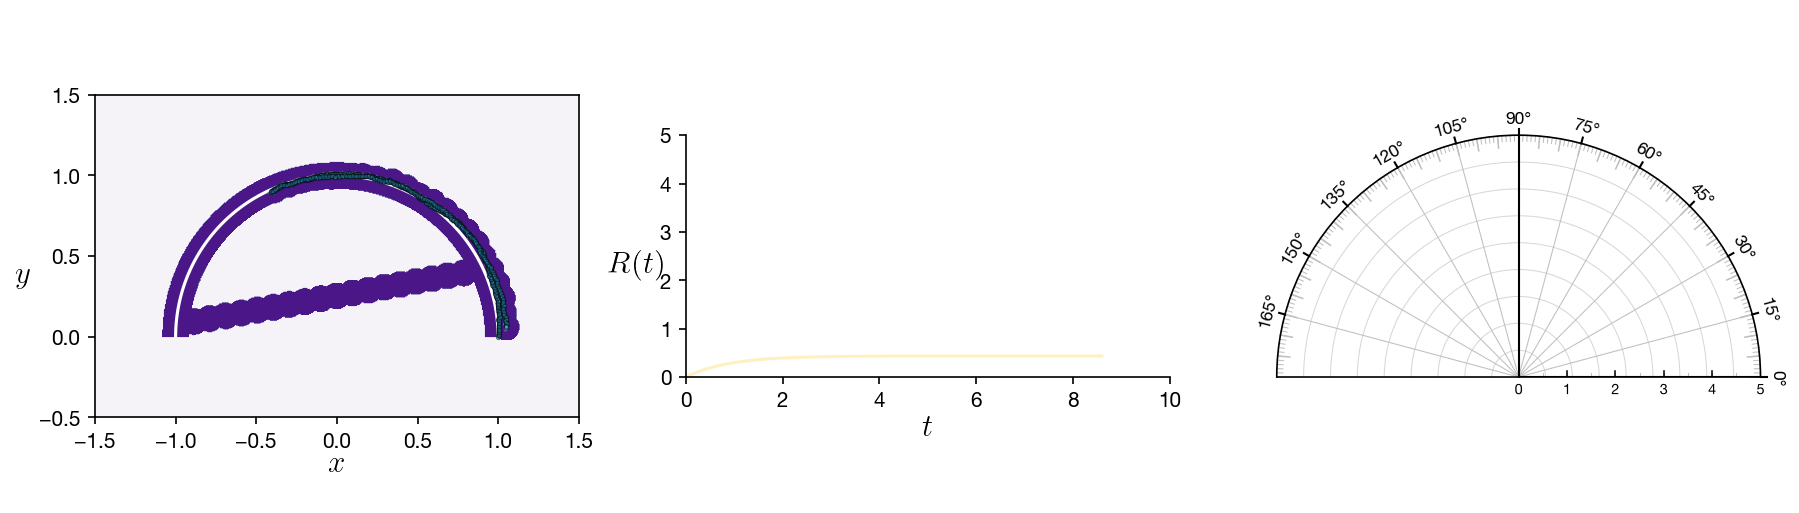

In [8]:
fig, ax = pF.plotDefMul(5, p, xphm, yphm, phm)
pF.plotMultFg(fig, ax, p, rfgxFull, rfgyFull, phfgxFull, phfgyFull, rwdFull, fg.valFn, 0.5)
plt.show()

In [8]:
importlib.reload(pF)
# pF.plotVidFn(p, xphm, yphm, phm, rxFull, ryFull, phxFull, phyFull)
pF.plotMulVidFn(p, xphm, yphm, phm, rxFull, ryFull, phxFull, phyFull, rfgxFull, rfgyFull, phfgxFull, phfgyFull)

! rm MultiAgent.mp4
! ffmpeg -r 10 -i "Multi%d.png" -c:v libx264 -vf fps=20 -pix_fmt yuv420p ./MultiAgent.mp4

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --di

In [9]:
! rm Multi*.png